Generation: 15000. Loss = 0.02736655 ,  Test Loss = 0.030201383


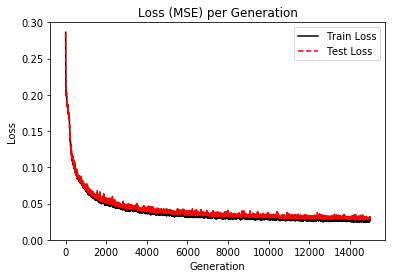

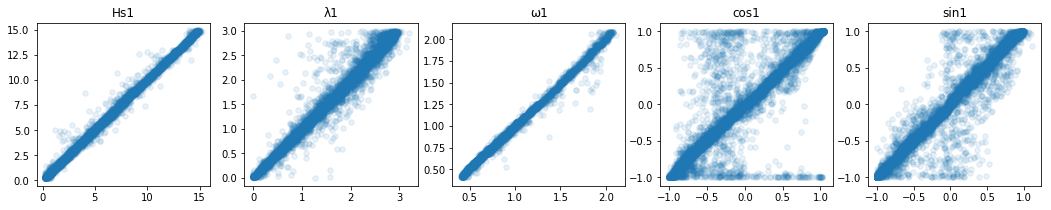

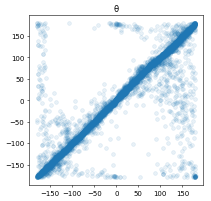

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import math
import os
import pandas as pd
import numpy as np
from tensorflow.python.framework import ops
import matplotlib
%matplotlib inline
plt.ion()
from random import randint
import time
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
ops.reset_default_graph()

input_shape_rows   =16  #入力データの行
input_shape_columns=71  #入力データの列
output_shape= 5         #出力の

#csvファイルの読み込み
inputdata = pd.read_csv('39181set.csv', encoding='shift_jis')
a_df = inputdata.values

#結果を再現可能にするためのランダムシードを作成
seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

#入力変数と出力変数の指定
#x_vals = np.array([x[0:816] for x in a_df])
#y_vals = np.array([x[816:821] for x in a_df])
xdata = np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
ydata  = np.array([x[input_shape_rows*input_shape_columns:input_shape_rows*input_shape_columns+output_shape] for x in a_df])

#正規化の定義
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max-col_min) 

#データの最大値と最小値を保存
col_max0 = ydata.max(axis=0)
col_min0 = ydata.min(axis=0) 


#正規化の実行
#x_vals0 = np.nan_to_num(normalize_cols(x_vals))   #入力の正規化は必要？
ydata_0 = np.nan_to_num(normalize_cols(ydata))


#訓練データとテストデータを8：2に分割
train_indices = np.random.choice(len(xdata), round(len(xdata)*0.8), replace=False)  #訓練データに使うindex
test_indices  = np.array(list(set(range(len(xdata))) - set(train_indices)))         #テストデータに使うindex
train_xdata   = xdata[train_indices]    #入力データの訓練集合
test_xdata    = xdata[test_indices]     #入力データのテスト集合
train_ydata   = ydata_0[train_indices]  #出力データの訓練集合(正規化済み)
test_ydata    = ydata_0[test_indices]   #出力データのテスト集合(正規化済み)
test_ydata_origin    = ydata[test_indices] #出力データのテスト集合(正解値)

# Convert labels into one-hot encoded vectors
#train_labels = mnist.train.labels
#test_labels = mnist.test.labels

sess=tf.Session()

# Set model parameters
batch_size = 512#512行5列
learning_rate = 0.005
evaluation_size = len(test_indices)   #テストデータに使うデータ数
image_height =train_xdata[0].shape[0]   #行
image_width  = train_xdata[0].shape[1]  #列
#target_size = 5#np.max(train_labels) + 1 
target_size = output_shape #(16,51)#(len(train_ydata),output_shape)  #(訓練データ数,出力個数=5)
num_channels = 1 # greyscale = 1 channel
generations = 15000  #計算回数
eval_every =100     #100世代ごとにプロット
conv1_features = 8  #1回目の畳み込みの枚数
filter_size1=10
conv2_features = 16#2回目の畳み込みの枚数
filter_size2=6
max_pool_size1 = 2 # NxN window for 1st max pool layerプーリング層
max_pool_size2 = 2 # NxN window for 2nd max pool layer　プーリング層
fully_connected_size1 = 80   #全結合層のノード数?
fully_connected_size2 = 45
fully_connected_size3 = 20

#入力[512,16,51,1]
x_input_shape = (batch_size, image_height, image_width,num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
#出力データ[512,5]
y_target = tf.placeholder(tf.float32, shape=(batch_size,output_shape))   

#入力[512,16,51,1]
x_input_shape2 = (len(train_indices), image_height, image_width,num_channels)
x_input2 = tf.placeholder(tf.float32, shape=x_input_shape2)
#出力データ[512,5]
y_target2 = tf.placeholder(tf.float32, shape=(len(train_indices),output_shape))   


#評価は、一部のデータに対して行う
#テストデータの入力(500,16,51,1)
eval_input_shape = (evaluation_size, image_height, image_width,num_channels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
#テストデータの出力データ(500,5)
eval_target = tf.placeholder(tf.float32, shape=(evaluation_size,output_shape))


# 畳み込み層
#一枚目の畳み込み[1行,6列,60枚]
conv1_weight = tf.Variable(tf.truncated_normal([1, filter_size1,num_channels,  conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.truncated_normal([conv1_features], dtype=tf.float32))
#2枚目の畳み込み[1行,4列,30枚]
conv2_weight = tf.Variable(tf.truncated_normal([1, filter_size2 , conv1_features, conv2_features],stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.truncated_normal([conv2_features], dtype=tf.float32))

# 全結合層
resulting_width = int(((image_width-filter_size1+1)/max_pool_size1-filter_size2+1)/max_pool_size2)# // (max_pool_size1 * max_pool_size2)
resulting_height = image_height# // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features  #全結合層(プーリングマップサイズ*チャネル数)
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1,dtype=tf.float32))
full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, fully_connected_size2],stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([fully_connected_size2], stddev=0.1, dtype=tf.float32))  #(訓練データ数,出力個数=5)
full3_weight = tf.Variable(tf.truncated_normal([fully_connected_size2,fully_connected_size3],stddev=0.1, dtype=tf.float32))
full3_bias = tf.Variable(tf.truncated_normal([fully_connected_size3], stddev=0.1, dtype=tf.float32))
full4_weight = tf.Variable(tf.truncated_normal([fully_connected_size3, target_size],stddev=0.1, dtype=tf.float32))
full4_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
#±2σの切断正規分布からランダムに取り出したテンソルを生成する。stddev: 生成する切断正規分布の標準偏差

"""After we have the layer variables, we can create the model operations.
(Convolutional layer 1) --> (ReLU 1) --> (Max Pool 1) -->(Convolutional layer 2) --> (ReLU 2) --> (Max Pool 2) -->
-->(Fully Connected Layer 1) --> (Fully Connected Layer 2) --> Prediction."""

# Initialize Model Operations
def my_conv_net(input_data):
    # First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='VALID')#ゼロパディングを利用する場合はSAMEを指定
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, 1, max_pool_size1, 1],strides=[1, 1, max_pool_size1, 1], padding='VALID')
    
    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='VALID')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, 1, max_pool_size2, 1],strides=[1, 1, max_pool_size2, 1], padding='VALID')

    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = tf.cast(final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3], tf.float32) #6120
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])

    # First Fully Connected Layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    fully_connected2 = tf.nn.relu(tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias))
    fully_connected3 = tf.nn.sigmoid(tf.add(tf.matmul(fully_connected2, full3_weight), full3_bias))

    # Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connected3, full4_weight), full4_bias)
    
    return final_model_output

model_output = my_conv_net(x_input)
model_output2 = my_conv_net(x_input2)
test_model_output = my_conv_net(eval_input)


#loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
#損失関数
loss = tf.reduce_mean(tf.abs(model_output - tf.cast(y_target, tf.float32)))
loss2 = tf.reduce_mean(tf.abs(model_output2 - tf.cast(y_target2, tf.float32)))
eval_loss = tf.reduce_mean(tf.abs(test_model_output - tf.cast(eval_target, tf.float32)))


#勾配降下法と最適化
my_optimizer = tf.train.AdamOptimizer(0.005)# tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)

# Create a prediction function
prediction = tf.nn.relu(model_output)
prediction2 = tf.nn.relu(model_output2)
test_prediction = tf.nn.relu(test_model_output)

# Create accuracy function
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(logits, targets))
    return 100. * num_correct/batch_predictions.shape[0]

# Create an optimizer



# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

siz = 10
dat = np.zeros((siz, siz))
fig, (axe_H,axe_lambda, axe_w,axe_cos,axe_sin) = plt.subplots(ncols=5, figsize=(15,5))

# Start training loop
train_loss = []
test_loss=[]
train_acc = []
test_acc = []
print("start")
for i in range(generations):

    #print(i+1)
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]      #入力データの訓練集合からバッチサイズ分取り出す
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_ydata[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    
    temp_train_xdata=train_xdata
    temp_train_xdata=np.expand_dims(temp_train_xdata ,3)
    temp_train_loss,temp_train_preds = sess.run( [loss2,prediction2], feed_dict={x_input2: temp_train_xdata, y_target2: train_ydata})#train_dict

    #temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    eval_index = np.random.choice(len(test_xdata), size=evaluation_size)
    eval_x = test_xdata#[eval_index]
    eval_x = np.expand_dims(eval_x, 3)
    eval_y = test_ydata#[eval_index]
    test_dict = {eval_input: eval_x,  eval_target: eval_y}

    temp_test_loss,test_preds = sess.run([eval_loss,test_prediction], feed_dict=test_dict)#temp_test_loss,
    #temp_test_acc = get_accuracy(test_preds, eval_y)


    # Record and print results
    train_loss.append(temp_train_loss)
    test_loss.append(temp_test_loss)
    
    if (i+1) % eval_every == 0:
        clear_output(wait = True)
        plt.close()
        #train_acc.append(temp_train_acc)
        #test_acc.append(temp_test_acc)
        #acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        #acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        #print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_train_loss)+" ,  Test Loss = "+str(temp_test_loss))
        #グラフをプロット
        plt.plot(train_loss, 'k-', label='Train Loss')
        plt.plot(test_loss, 'r--', label='Test Loss')
        plt.title('Loss (MSE) per Generation')
        plt.ylim(0,0.30)
        plt.legend(loc='upper right')
        plt.xlabel('Generation')
        plt.ylabel('Loss')
        plt.show()
        
        axe_H.scatter(test_preds[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],test_ydata_origin[:,0:1],s=30, alpha=0.1)#*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]
        axe_H.set_title('Hs1')
        axe_w.scatter(test_preds[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],test_ydata_origin[:,4:5],s=30, alpha=0.1)#*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]
        axe_w.set_title('ω1')
        axe_cos.scatter(test_preds[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],test_ydata_origin[:,1:2],s=30, alpha=0.1)#*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2]
        axe_cos.set_title('cos1')
        axe_sin.scatter(test_preds[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_ydata_origin[:,2:3],s=30, alpha=0.1)#*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3]
        axe_sin.set_title('sin1')
        axe_lambda.scatter(test_preds[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],test_ydata_origin[:,3:4],s=30, alpha=0.1)#*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]
        axe_lambda.set_title('λ1')
        fig.set_size_inches(18,3)
        display(fig)
        #time.sleep(.2)
        #axe_loss.cla()
        axe_H.cla()
        axe_w.cla()
        axe_cos.cla()
        axe_sin.cla()
        axe_lambda.cla()
        
        D_kaku=np.zeros(len(test_preds[:,4:5]))
        y_val_kaku=np.zeros(len(test_preds[:,4:5]))
        for i in range(len(test_preds[:,4:5])):
            D_kaku[i]=math.atan2(test_preds[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
            y_val_kaku[i]=math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])*180/np.pi

        plt.figure(figsize=(4.5,4.5),dpi=50)
        plt.scatter(D_kaku,y_val_kaku,s=30, alpha=0.1)
        plt.title('θ')
        plt.show()
        
    

In [2]:
retsu=0
R = tf.reduce_mean((test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(test_ydata_origin[:,retsu:retsu+1]-tf.reduce_mean(test_ydata_origin[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(test_ydata_origin[:,retsu:retsu+1]-tf.reduce_mean(test_ydata_origin[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input: eval_x,  eval_target: eval_y})
print("H: "+str(temp_acc_test41))
retsu=4
R = tf.reduce_mean((test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(test_ydata_origin[:,retsu:retsu+1]-tf.reduce_mean(test_ydata_origin[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(test_ydata_origin[:,retsu:retsu+1]-tf.reduce_mean(test_ydata_origin[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input: eval_x,  eval_target: eval_y})
print("w: "+str(temp_acc_test41))
retsu=3
R = tf.reduce_mean((test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(test_ydata_origin[:,retsu:retsu+1]-tf.reduce_mean(test_ydata_origin[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(test_ydata_origin[:,retsu:retsu+1]-tf.reduce_mean(test_ydata_origin[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input: eval_x,  eval_target: eval_y})
print("Lambda: "+str(temp_acc_test41))

H: 0.998036976676787
w: 0.997302356672482
Lambda: 0.9832285514837508


In [3]:
Sxy,Sxx,Syy=0,0,0
for i in range(len(test_preds[:,4:5])-1):
    for j in range(i+1,len(test_preds[:,4:5])):
        Sxy +=math.sin(math.atan2(test_preds[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))*math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))
        Sxx += math.sin(math.atan2(test_preds[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))**2
        Syy += math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))**2

Rc=Sxy/(math.sqrt(Sxx*Syy))
print(Rc)  

0.8316303594206578


## データ編集

In [72]:
Test_indices_LowFreq=[]
Test_indices_HighFreq=[]
Test_indices_HighFreq_005_030=[]
Test_indices_HighFreq_030_060=[]
Test_indices_HighFreq_060_100=[]
for i in test_indices:
    if a_df[i][1140]<=2*np.pi/6:
        Test_indices_LowFreq.append(i)
    else:
        Test_indices_HighFreq.append(i)
        if  3.00>=a_df[i][1136]:
            Test_indices_HighFreq_005_030.append(i)
        elif 3.00<=a_df[i][1136] and a_df[i][1136]<=6.00:
            Test_indices_HighFreq_030_060.append(i)
        else:
            Test_indices_HighFreq_060_100.append(i)
print("end")

end


## 高周波込みのデータを学習させたCNNに，高周波除いたデータを入力

データ数: 5908
RMSE: 1.9234848


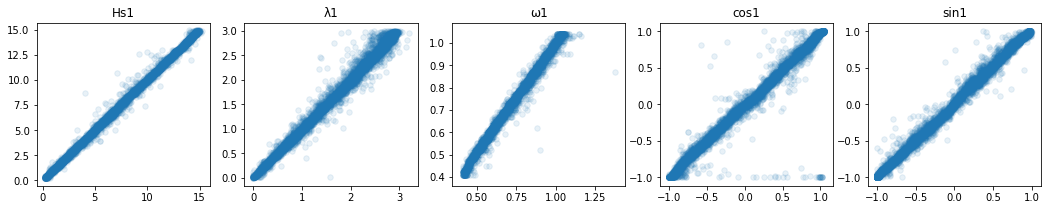

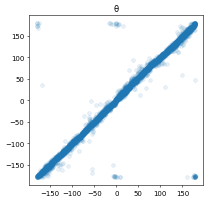

In [88]:
xdata2 =np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
xdata2 = np.expand_dims(xdata2, 3)
xdata2 =xdata2[Test_indices_LowFreq]
ydata2 =ydata[Test_indices_LowFreq]
test_ydata_origin= ydata_0[Test_indices_LowFreq] 

eval_input_shape2 = (len(ydata2[:,0:1]), image_height, image_width,num_channels)
eval_input2 = tf.placeholder(tf.float32, shape=eval_input_shape2)
test_model_output2 = my_conv_net(eval_input2)
test_prediction2 = tf.nn.relu(test_model_output2)

eval_target2 = tf.placeholder(tf.float32, shape=(len(ydata2[:,0:1]),output_shape))
eval_loss2 = tf.reduce_mean(tf.abs(test_model_output2 - tf.cast(eval_target2, tf.float32)))

test_dict2 = {eval_input2: xdata2,  eval_target2: ydata2}
test_loss2,test_preds2 = sess.run([eval_loss2,test_prediction2], feed_dict=test_dict2)

print("データ数: "+str(len(ydata2[:,0:1])))
print("RMSE: "+str(test_loss2))


axe_H.scatter(test_preds2[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],ydata2[:,0:1],s=30, alpha=0.1)
axe_H.set_title('Hs1')
axe_w.scatter(test_preds2[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],ydata2[:,4:5],s=30, alpha=0.1)#
axe_w.set_title('ω1')
axe_cos.scatter(test_preds2[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],ydata2[:,1:2],s=30, alpha=0.1)#
axe_cos.set_title('cos1')
axe_sin.scatter(test_preds2[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],ydata2[:,2:3],s=30, alpha=0.1)#
axe_sin.set_title('sin1')
axe_lambda.scatter(test_preds2[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],ydata2[:,3:4],s=30, alpha=0.1)#
axe_lambda.set_title('λ1')
fig.set_size_inches(18,3)
display(fig)
#time.sleep(.2)
#axe_loss.cla()
axe_H.cla()
axe_w.cla()
axe_cos.cla()
axe_sin.cla()
axe_lambda.cla()

D_kaku1=np.zeros(len(test_preds2[:,4:5]))
y_val_kaku1=np.zeros(len(test_preds2[:,4:5]))
for i in range(len(test_preds2[:,4:5])):
    D_kaku1[i]=math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
    y_val_kaku1[i]=math.atan2(ydata2[i][2:3],ydata2[i][1:2])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku1,y_val_kaku1,s=30, alpha=0.1)
plt.title('θ')
plt.show()

In [71]:
retsu=0
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("H: "+str(temp_acc_test41))
retsu=4
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("w: "+str(temp_acc_test41))
retsu=3
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("Lambda: "+str(temp_acc_test41))

H: 0.9983494859671552
w: 0.994669635919578
Lambda: 0.9929458913696434


In [90]:
Sxy,Sxx,Syy=0,0,0
for i in range(len(xdata2)-1):
    for j in range(i+1,len(test_preds2[:,4:5])):
        Sxy +=math.sin(math.atan2(test_preds2[i][2:3]*2-1,test_preds2[i][1:2]*2-1)-math.atan2(test_preds2[j][2:3]*2-1,test_preds2[j][1:2]*2-1 ))*math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))
        Sxx += math.sin(math.atan2(test_preds2[i][2:3]*2-1,test_preds2[i][1:2]*2-1)-math.atan2(test_preds2[j][2:3]*2-1,test_preds2[j][1:2]*2-1 ))**2
        Syy += math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))**2

Rc=Sxy/(math.sqrt(Sxx*Syy))
print(Rc)  

0.08298427653227602


## 高周波込みのデータを学習させたCNNに，高周波のみのデータを入力

データ数: 1928
RMSE: 1.4222761


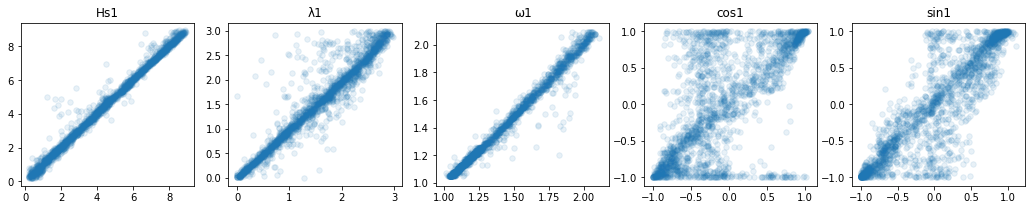

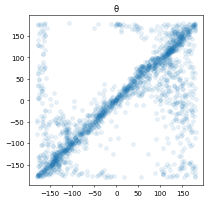

In [75]:
xdata2 =np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
xdata2 = np.expand_dims(xdata2, 3)
xdata2 =xdata2[Test_indices_HighFreq]
ydata2 =ydata[Test_indices_HighFreq]
test_ydata_origin = ydata_0[Test_indices_HighFreq] 

eval_input_shape2 = (len(ydata2[:,0:1]), image_height, image_width,num_channels)
eval_input2 = tf.placeholder(tf.float32, shape=eval_input_shape2)
test_model_output2 = my_conv_net(eval_input2)
test_prediction2 = tf.nn.relu(test_model_output2)

eval_target2 = tf.placeholder(tf.float32, shape=(len(ydata2[:,0:1]),output_shape))
eval_loss2 = tf.reduce_mean(tf.abs(test_model_output2 - tf.cast(eval_target2, tf.float32)))

test_dict2 = {eval_input2: xdata2,  eval_target2: ydata2}
test_loss2,test_preds2 = sess.run([eval_loss2,test_prediction2], feed_dict=test_dict2)

print("データ数: "+str(len(ydata2[:,0:1])))
print("RMSE: "+str(test_loss2))


axe_H.scatter(test_preds2[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],ydata2[:,0:1],s=30, alpha=0.1)
axe_H.set_title('Hs1')
axe_w.scatter(test_preds2[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],ydata2[:,4:5],s=30, alpha=0.1)#
axe_w.set_title('ω1')
axe_cos.scatter(test_preds2[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],ydata2[:,1:2],s=30, alpha=0.1)#
axe_cos.set_title('cos1')
axe_sin.scatter(test_preds2[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],ydata2[:,2:3],s=30, alpha=0.1)#
axe_sin.set_title('sin1')
axe_lambda.scatter(test_preds2[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],ydata2[:,3:4],s=30, alpha=0.1)#
axe_lambda.set_title('λ1')
fig.set_size_inches(18,3)
display(fig)
#time.sleep(.2)
#axe_loss.cla()
axe_H.cla()
axe_w.cla()
axe_cos.cla()
axe_sin.cla()
axe_lambda.cla()

D_kaku1=np.zeros(len(test_preds2[:,4:5]))
y_val_kaku1=np.zeros(len(test_preds2[:,4:5]))
for i in range(len(test_preds2[:,4:5])):
    D_kaku1[i]=math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
    y_val_kaku1[i]=math.atan2(ydata2[i][2:3],ydata2[i][1:2])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku1,y_val_kaku1,s=30, alpha=0.1)
plt.title('θ')
plt.show()

In [76]:
retsu=0
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("H: "+str(temp_acc_test41))
retsu=4
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("w: "+str(temp_acc_test41))
retsu=3
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("Lambda: "+str(temp_acc_test41))

H: 0.9933929290593831
w: 0.9896675866838879
Lambda: 0.9512294562525315


In [ ]:
Sxy,Sxx,Syy=0,0,0
for i in range(len(test_preds[:,4:5])-1):
    for j in range(i+1,len(test_preds[:,4:5])):
        Sxy +=math.sin(math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds2[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))*math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))
        Sxx += math.sin(math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds2[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))**2
        Syy += math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))**2

Rc=Sxy/(math.sqrt(Sxx*Syy))
print(Rc)  

## 高周波で波高3m以下のデータを入力

データ数: 657
RMSE: 0.90693694


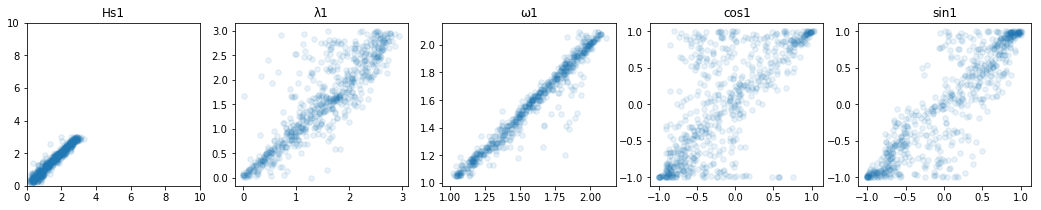

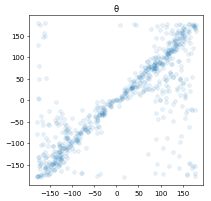

In [91]:
xdata2 =np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
xdata2 = np.expand_dims(xdata2, 3)
xdata2 =xdata2[Test_indices_HighFreq_005_030]
ydata2 =ydata[Test_indices_HighFreq_005_030]
test_ydata_origin = ydata_0[Test_indices_HighFreq_005_030] 

eval_input_shape2 = (len(ydata2[:,0:1]), image_height, image_width,num_channels)
eval_input2 = tf.placeholder(tf.float32, shape=eval_input_shape2)
test_model_output2 = my_conv_net(eval_input2)
test_prediction2 = tf.nn.relu(test_model_output2)

eval_target2 = tf.placeholder(tf.float32, shape=(len(ydata2[:,0:1]),output_shape))
eval_loss2 = tf.reduce_mean(tf.abs(test_model_output2 - tf.cast(eval_target2, tf.float32)))

test_dict2 = {eval_input2: xdata2,  eval_target2: ydata2}
test_loss2,test_preds2 = sess.run([eval_loss2,test_prediction2], feed_dict=test_dict2)

print("データ数: "+str(len(ydata2[:,0:1])))
print("RMSE: "+str(test_loss2))


axe_H.scatter(test_preds2[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],ydata2[:,0:1],s=30, alpha=0.1)
axe_H.set_title('Hs1')
axe_H.set_xlim([0,10])
axe_H.set_ylim([0,10])
axe_w.scatter(test_preds2[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],ydata2[:,4:5],s=30, alpha=0.1)#
axe_w.set_title('ω1')
axe_cos.scatter(test_preds2[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],ydata2[:,1:2],s=30, alpha=0.1)#
axe_cos.set_title('cos1')
axe_sin.scatter(test_preds2[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],ydata2[:,2:3],s=30, alpha=0.1)#
axe_sin.set_title('sin1')
axe_lambda.scatter(test_preds2[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],ydata2[:,3:4],s=30, alpha=0.1)#
axe_lambda.set_title('λ1')
fig.set_size_inches(18,3)
display(fig)
#time.sleep(.2)
#axe_loss.cla()
axe_H.cla()
axe_w.cla()
axe_cos.cla()
axe_sin.cla()
axe_lambda.cla()

D_kaku1=np.zeros(len(test_preds2[:,4:5]))
y_val_kaku1=np.zeros(len(test_preds2[:,4:5]))
for i in range(len(test_preds2[:,4:5])):
    D_kaku1[i]=math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
    y_val_kaku1[i]=math.atan2(ydata2[i][2:3],ydata2[i][1:2])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku1,y_val_kaku1,s=30, alpha=0.1)
plt.title('θ')
plt.show()

In [78]:
retsu=0
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("H: "+str(temp_acc_test41))
retsu=4
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("w: "+str(temp_acc_test41))
retsu=3
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("Lambda: "+str(temp_acc_test41))

H: 0.9684038065620495
w: 0.9714432201913361
Lambda: 0.8685850383323254


In [ ]:
Sxy,Sxx,Syy=0,0,0
for i in range(len(test_preds[:,4:5])-1):
    for j in range(i+1,len(test_preds[:,4:5])):
        Sxy +=math.sin(math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds2[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))*math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))
        Sxx += math.sin(math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds2[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))**2
        Syy += math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))**2

Rc=Sxy/(math.sqrt(Sxx*Syy))
print(Rc)  

## 高周波で波高3m以上6m以下のデータを入力

データ数: 661
RMSE: 1.455268


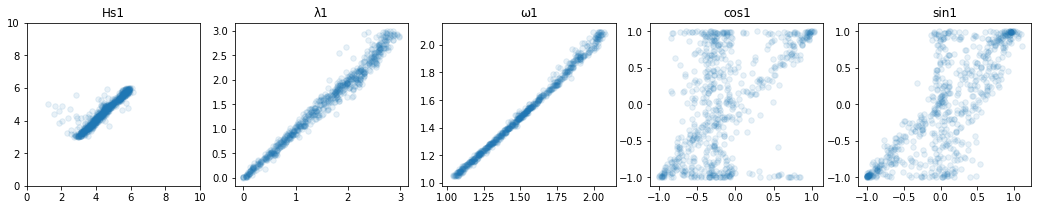

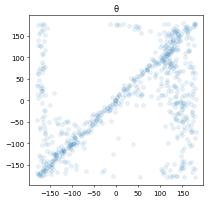

In [79]:
xdata2 =np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
xdata2 = np.expand_dims(xdata2, 3)
xdata2 =xdata2[Test_indices_HighFreq_030_060]
ydata2 =ydata[Test_indices_HighFreq_030_060]
test_ydata_origin = ydata_0[Test_indices_HighFreq_030_060] 

eval_input_shape2 = (len(ydata2[:,0:1]), image_height, image_width,num_channels)
eval_input2 = tf.placeholder(tf.float32, shape=eval_input_shape2)
test_model_output2 = my_conv_net(eval_input2)
test_prediction2 = tf.nn.relu(test_model_output2)

eval_target2 = tf.placeholder(tf.float32, shape=(len(ydata2[:,0:1]),output_shape))
eval_loss2 = tf.reduce_mean(tf.abs(test_model_output2 - tf.cast(eval_target2, tf.float32)))

test_dict2 = {eval_input2: xdata2,  eval_target2: ydata2}
test_loss2,test_preds2 = sess.run([eval_loss2,test_prediction2], feed_dict=test_dict2)

print("データ数: "+str(len(ydata2[:,0:1])))
print("RMSE: "+str(test_loss2))


axe_H.scatter(test_preds2[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],ydata2[:,0:1],s=30, alpha=0.1)
axe_H.set_title('Hs1')
axe_H.set_xlim([0,10])
axe_H.set_ylim([0,10])
axe_w.scatter(test_preds2[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],ydata2[:,4:5],s=30, alpha=0.1)#
axe_w.set_title('ω1')
axe_cos.scatter(test_preds2[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],ydata2[:,1:2],s=30, alpha=0.1)#
axe_cos.set_title('cos1')
axe_sin.scatter(test_preds2[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],ydata2[:,2:3],s=30, alpha=0.1)#
axe_sin.set_title('sin1')
axe_lambda.scatter(test_preds2[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],ydata2[:,3:4],s=30, alpha=0.1)#
axe_lambda.set_title('λ1')
fig.set_size_inches(18,3)
display(fig)
#time.sleep(.2)
#axe_loss.cla()
axe_H.cla()
axe_w.cla()
axe_cos.cla()
axe_sin.cla()
axe_lambda.cla()

D_kaku1=np.zeros(len(test_preds2[:,4:5]))
y_val_kaku1=np.zeros(len(test_preds2[:,4:5]))
for i in range(len(test_preds2[:,4:5])):
    D_kaku1[i]=math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
    y_val_kaku1[i]=math.atan2(ydata2[i][2:3],ydata2[i][1:2])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku1,y_val_kaku1,s=30, alpha=0.1)
plt.title('θ')
plt.show()

In [81]:
retsu=0
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("H: "+str(temp_acc_test41))
retsu=4
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("w: "+str(temp_acc_test41))
retsu=3
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("Lambda: "+str(temp_acc_test41))

H: 0.9045141162315474
w: 0.9971066342376004
Lambda: 0.9890186286061581


In [ ]:
Sxy,Sxx,Syy=0,0,0
for i in range(len(test_preds[:,4:5])-1):
    for j in range(i+1,len(test_preds[:,4:5])):
        Sxy +=math.sin(math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds2[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))*math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))
        Sxx += math.sin(math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds2[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))**2
        Syy += math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))**2

Rc=Sxy/(math.sqrt(Sxx*Syy))
print(Rc)  

## 高周波で波高6m以上

データ数: 610
RMSE: 1.9415721


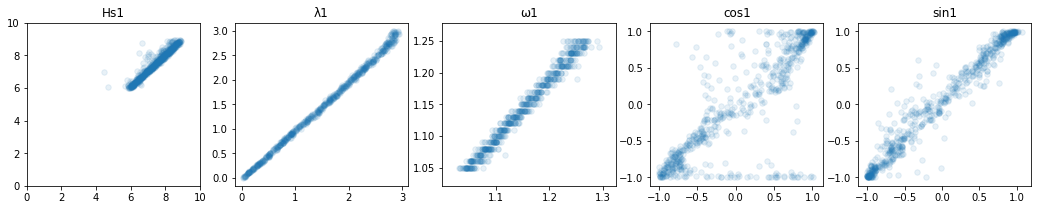

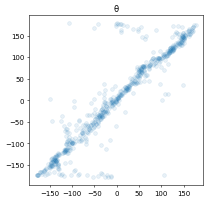

In [82]:
xdata2 =np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
xdata2 = np.expand_dims(xdata2, 3)
xdata2 =xdata2[Test_indices_HighFreq_060_100]
ydata2 =ydata[Test_indices_HighFreq_060_100]
test_ydata_origin = ydata_0[Test_indices_HighFreq_060_100] 

eval_input_shape2 = (len(ydata2[:,0:1]), image_height, image_width,num_channels)
eval_input2 = tf.placeholder(tf.float32, shape=eval_input_shape2)
test_model_output2 = my_conv_net(eval_input2)
test_prediction2 = tf.nn.relu(test_model_output2)

eval_target2 = tf.placeholder(tf.float32, shape=(len(ydata2[:,0:1]),output_shape))
eval_loss2 = tf.reduce_mean(tf.abs(test_model_output2 - tf.cast(eval_target2, tf.float32)))

test_dict2 = {eval_input2: xdata2,  eval_target2: ydata2}
test_loss2,test_preds2 = sess.run([eval_loss2,test_prediction2], feed_dict=test_dict2)

print("データ数: "+str(len(ydata2[:,0:1])))
print("RMSE: "+str(test_loss2))


axe_H.scatter(test_preds2[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],ydata2[:,0:1],s=30, alpha=0.1)
axe_H.set_title('Hs1')
axe_H.set_xlim([0,10])
axe_H.set_ylim([0,10])
axe_w.scatter(test_preds2[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],ydata2[:,4:5],s=30, alpha=0.1)#
axe_w.set_title('ω1')
axe_cos.scatter(test_preds2[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],ydata2[:,1:2],s=30, alpha=0.1)#
axe_cos.set_title('cos1')
axe_sin.scatter(test_preds2[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],ydata2[:,2:3],s=30, alpha=0.1)#
axe_sin.set_title('sin1')
axe_lambda.scatter(test_preds2[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],ydata2[:,3:4],s=30, alpha=0.1)#
axe_lambda.set_title('λ1')
fig.set_size_inches(18,3)
display(fig)
#time.sleep(.2)
#axe_loss.cla()
axe_H.cla()
axe_w.cla()
axe_cos.cla()
axe_sin.cla()
axe_lambda.cla()

D_kaku1=np.zeros(len(test_preds2[:,4:5]))
y_val_kaku1=np.zeros(len(test_preds2[:,4:5]))
for i in range(len(test_preds2[:,4:5])):
    D_kaku1[i]=math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
    y_val_kaku1[i]=math.atan2(ydata2[i][2:3],ydata2[i][1:2])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku1,y_val_kaku1,s=30, alpha=0.1)
plt.title('θ')
plt.show()

In [83]:
retsu=0
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("H: "+str(temp_acc_test41))
retsu=4
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("w: "+str(temp_acc_test41))
retsu=3
R = tf.reduce_mean((test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))*(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]-tf.reduce_mean(test_preds2[:,retsu:retsu+1]*(col_max0[retsu:retsu+1] - col_min0[retsu:retsu+1]) + col_min0[retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(ydata2[:,retsu:retsu+1]-tf.reduce_mean(ydata2[:,retsu:retsu+1])))))
temp_acc_test41 = sess.run(R, feed_dict={eval_input2: xdata2,  eval_target2: ydata2})
print("Lambda: "+str(temp_acc_test41))

H: 0.9612204072118825
w: 0.988491854512097
Lambda: 0.9987445617421444


## csvファイルに出力を保存

In [ ]:
Sxy,Sxx,Syy=0,0,0
for i in range(len(test_preds[:,4:5])-1):
    for j in range(i+1,len(test_preds[:,4:5])):
        Sxy +=math.sin(math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds2[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))*math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))
        Sxx += math.sin(math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] )-math.atan2(test_preds2[j][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[j][1:2]*(col_max0[1:2] - col_min0[1:2])+ col_min0[1:2] ))**2
        Syy += math.sin(math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])-math.atan2(test_ydata_origin[j][2:3],test_ydata_origin[j][1:2]))**2

Rc=Sxy/(math.sqrt(Sxx*Syy))
print(Rc)  

データ数: 7836
RMSE: 1.8001653


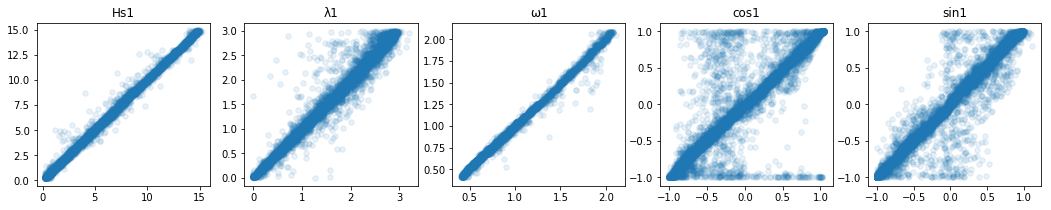

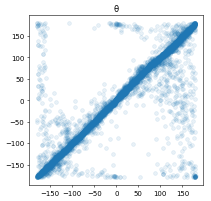

In [106]:
Indices=test_indices #ここを変える
xdata2 =np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
xdata2 = np.expand_dims(xdata2, 3)
xdata2 =xdata2[Indices]
ydata2 =ydata[Indices]
test_ydata_origin = ydata_0[Indices] 

eval_input_shape2 = (len(ydata2[:,0:1]), image_height, image_width,num_channels)
eval_input2 = tf.placeholder(tf.float32, shape=eval_input_shape2)
test_model_output2 = my_conv_net(eval_input2)
test_prediction2 = tf.nn.relu(test_model_output2)

eval_target2 = tf.placeholder(tf.float32, shape=(len(ydata2[:,0:1]),output_shape))
eval_loss2 = tf.reduce_mean(tf.abs(test_model_output2 - tf.cast(eval_target2, tf.float32)))

test_dict2 = {eval_input2: xdata2,  eval_target2: ydata2}
test_loss2,test_preds2 = sess.run([eval_loss2,test_prediction2], feed_dict=test_dict2)

print("データ数: "+str(len(ydata2[:,0:1])))
print("RMSE: "+str(test_loss2))


axe_H.scatter(test_preds2[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],ydata2[:,0:1],s=30, alpha=0.1)
axe_H.set_title('Hs1')
axe_w.scatter(test_preds2[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],ydata2[:,4:5],s=30, alpha=0.1)#
axe_w.set_title('ω1')
axe_cos.scatter(test_preds2[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],ydata2[:,1:2],s=30, alpha=0.1)#
axe_cos.set_title('cos1')
axe_sin.scatter(test_preds2[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],ydata2[:,2:3],s=30, alpha=0.1)#
axe_sin.set_title('sin1')
axe_lambda.scatter(test_preds2[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],ydata2[:,3:4],s=30, alpha=0.1)#
axe_lambda.set_title('λ1')
fig.set_size_inches(18,3)
display(fig)
#time.sleep(.2)
#axe_loss.cla()
axe_H.cla()
axe_w.cla()
axe_cos.cla()
axe_sin.cla()
axe_lambda.cla()

D_kaku1=np.zeros(len(test_preds2[:,4:5]))
y_val_kaku1=np.zeros(len(test_preds2[:,4:5]))
for i in range(len(test_preds2[:,4:5])):
    D_kaku1[i]=math.atan2(test_preds2[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_preds2[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
    y_val_kaku1[i]=math.atan2(ydata2[i][2:3],ydata2[i][1:2])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku1,y_val_kaku1,s=30, alpha=0.1)
plt.title('θ')
plt.show()

f=open("output_all.csv","w",encoding="UTF-8")
f.write("波高推定,cos推定,sin推定,λ推定,ω推定,波高正解,cos正解,sin正解,λ正解,ω正解")
f.write('\n')
for i in range(len(test_preds2[:,0:1])):
    f.write(str('%03.6f' %(test_preds2[i:i+1,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]))+","+str('%03.6f' %(test_preds2[i:i+1,1:2]*2-1))+","+str('%03.6f' %(test_preds2[i:i+1,2:3]*2-1))+","+str(test_preds2[i:i+1,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4])+","+str('%03.6f' %(test_preds2[i:i+1,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]))+",")
    f.write(str('%03.6f' %(ydata2[i:i+1,0:1]))+","+str('%03.6f' %(ydata2[i:i+1,1:2]))+","+str('%03.6f' %(ydata2[i:i+1,2:3]))+","+str(ydata2[i:i+1,3:4])+","+str('%03.6f' %(ydata2[i:i+1,4:5])))
    f.write('\n')
f.close()

In [104]:
print("start")
f=open("output_1029.csv","w",encoding="UTF-8")
for i in range(len(test_preds2[:,0:1])):
    sabun= np.abs(math.atan2(test_preds2[i:i+1,2:3]*2-1,test_preds2[i:i+1,1:2]*2-1)-math.atan2(ydata2[i:i+1,2:3]*2-1,ydata2[i:i+1,1:2]*2-1))*360/2/np.pi
    if sabun>=200 and sabun<=300:
        f.write(str('%03.6f' %(test_preds2[i:i+1,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]))+","+str('%03.6f' %(test_preds2[i:i+1,1:2]*2-1))+","+str('%03.6f' %(test_preds2[i:i+1,2:3]*2-1))+","+str(test_preds2[i:i+1,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4])+","+str('%03.6f' %(test_preds2[i:i+1,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]))+",")
        f.write(str('%03.6f' %(ydata2[i:i+1,0:1]))+","+str('%03.6f' %(ydata2[i:i+1,1:2]))+","+str('%03.6f' %(ydata2[i:i+1,2:3]))+","+str(ydata2[i:i+1,3:4])+","+str('%03.6f' %(ydata2[i:i+1,4:5])))
        f.write('\n')
f.close()
print("end")

start
end


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import math
import os
import pandas as pd
import numpy as np
from tensorflow.python.framework import ops
import matplotlib
%matplotlib inline
plt.ion()
from random import randint
import time
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
ops.reset_default_graph()

input_shape_rows   =16  #入力データの行
input_shape_columns=71  #入力データの列
output_shape= 5         #出力の

#csvファイルの読み込み
inputdata = pd.read_csv('39181set.csv', encoding='shift_jis')
a_df = inputdata.values

#結果を再現可能にするためのランダムシードを作成
seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

#入力変数と出力変数の指定
#x_vals = np.array([x[0:816] for x in a_df])
#y_vals = np.array([x[816:821] for x in a_df])
#xdata = np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
ydata  = np.array([x[input_shape_rows*input_shape_columns:input_shape_rows*input_shape_columns+output_shape] for x in a_df])
print(ydata[0:1,:])
print(ydata[0:1,:].shape)

[[3.61       0.444134   0.895961   0.00421417 0.78      ]]
(1, 5)
